## fxn/utils import

In [1]:
import optax
import time
import json
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap, jit, value_and_grad
import optax
import time
import functools as ft
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def activation_fn_load(act_func):
    if act_func == 'tanh':
        activation = jnp.tanh
    if act_func == 'relu':
        activation = jax.nn.relu
    if act_func == 'swish':
        activation = jax.nn.swish
    if act_func == 'sine':
        activation = jnp.sin
    if act_func == 'cosine':
        activation = jnp.cos
    if act_func == 'gelu':
        activation = jax.nn.gelu
    return activation

class DeepONet(eqx.Module):
   trunk: eqx.nn.MLP
   branch: eqx.nn.MLP
   
   def __init__(
         self, 
         TRUNK_INPUT_DIM , TRUNK_OUTPUT_DIM , TRUNK_WIDTH , TRUNK_DEPTH , TRUNK_ACT ,
         BRANCH_INPUT_DIM, BRANCH_OUTPUT_DIM, BRANCH_WIDTH, BRANCH_DEPTH, BRANCH_ACT, 
         *, key
   ):
      key, subkey_trunk, subkey_branch = jr.split(key, num=3)
      self.trunk  = eqx.nn.MLP(in_size=TRUNK_INPUT_DIM , out_size=TRUNK_OUTPUT_DIM , width_size=TRUNK_WIDTH , depth=TRUNK_DEPTH , activation=activation_fn_load(TRUNK_ACT) , key=subkey_trunk)
      self.branch = eqx.nn.MLP(in_size=BRANCH_INPUT_DIM, out_size=BRANCH_OUTPUT_DIM, width_size=BRANCH_WIDTH, depth=BRANCH_DEPTH, activation=activation_fn_load(BRANCH_ACT), key=subkey_branch)

   def __call__(self, f, x):
      trunk  = jnp.concatenate([self.trunk(x),jnp.ones((1,))])
      branch = self.branch(f)
      return jnp.dot(trunk, branch)

def create_DeepONet(*, key, HYPER_MODEL):
    TRUNK_INPUT_DIM   = HYPER_MODEL["TRUNK"]["input_dim"]
    TRUNK_OUTPUT_DIM  = HYPER_MODEL["TRUNK"]["output_dim"]
    TRUNK_WIDTH       = HYPER_MODEL["TRUNK"]["width"]
    TRUNK_DEPTH       = HYPER_MODEL["TRUNK"]["depth"]
    TRUNK_ACT         = HYPER_MODEL["TRUNK"]["act_func"]
    BRANCH_INPUT_DIM  = HYPER_MODEL["BRANCH"]["input_dim"]
    BRANCH_OUTPUT_DIM = HYPER_MODEL["BRANCH"]["output_dim"]
    BRANCH_WIDTH      = HYPER_MODEL["BRANCH"]["width"]
    BRANCH_DEPTH      = HYPER_MODEL["BRANCH"]["depth"]
    BRANCH_ACT        = HYPER_MODEL["BRANCH"]["act_func"]
    model = DeepONet(key=key, 
                     TRUNK_INPUT_DIM=TRUNK_INPUT_DIM, 
                     TRUNK_OUTPUT_DIM=TRUNK_OUTPUT_DIM, 
                     TRUNK_WIDTH=TRUNK_WIDTH, 
                     TRUNK_DEPTH=TRUNK_DEPTH, 
                     TRUNK_ACT=TRUNK_ACT,
                     BRANCH_INPUT_DIM=BRANCH_INPUT_DIM, 
                     BRANCH_OUTPUT_DIM=BRANCH_OUTPUT_DIM, 
                     BRANCH_WIDTH=BRANCH_WIDTH, 
                     BRANCH_DEPTH=BRANCH_DEPTH, 
                     BRANCH_ACT=BRANCH_ACT)
    return model

def load_DeepONet(filename):
    with open(filename, "rb") as f:
        hyperparams = json.loads(f.readline().decode())
        model = create_DeepONet(key=jr.PRNGKey(0), HYPER_MODEL=hyperparams)
        return eqx.tree_deserialise_leaves(f, model)


def create_FNN(*, key, input_dim, output_dim, width, depth, act_func):
    activation = activation_fn_load(act_func)
    return eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=width, depth=depth, activation=activation, key=key)

def save_MODEL(filename, hyperparams, model):
    with open(filename, "wb") as f:
        hyperparam_str = json.dumps(hyperparams)
        f.write((hyperparam_str + "\n").encode())
        eqx.tree_serialise_leaves(f, model)

def load_FNN(filename):
    with open(filename, "rb") as f:
        hyperparams = json.loads(f.readline().decode())
        model = create_FNN(key=jr.PRNGKey(0), **hyperparams)
        return eqx.tree_deserialise_leaves(f, model)

def create_OPTIMIZER(optim_hyperparams):
    LR0   = optim_hyperparams['LEARNING_RATE_INITIAL']
    if optim_hyperparams['LEARNING_RATE_SCHEDULER'] == 'exponential':
        STEP  = optim_hyperparams['LEARNING_RATE_STEP']
        DECAY = optim_hyperparams['LEARNING_RATE_DECAY']
        LEARNING_RATE = optax.schedules.exponential_decay(LR0, STEP, DECAY)
    else:
        LEARNING_RATE = LR0
    
    OPTIM_NAME = optim_hyperparams['NAME']
    print(f'Selected Optimizer is [ {OPTIM_NAME} ], Initial Learning Rate is {LR0:1.2e}')
    if optim_hyperparams['LEARNING_RATE_SCHEDULER'] == 'exponential':
        print(f'You are using [ exponential ] learning rate scheduler with rate: {DECAY:.2f} and step: {STEP}')
    else:
        print(f'You are using [ constant ] learning rate')
            
    if OPTIM_NAME == 'adabelief':
        optimizer = optax.adabelief(LEARNING_RATE)
    if OPTIM_NAME == 'adadelta':
        optimizer = optax.adadelta(LEARNING_RATE)
    if OPTIM_NAME == 'adan':
        optimizer = optax.adan(LEARNING_RATE)
    if OPTIM_NAME == 'adafactor':
        optimizer = optax.adafactor(LEARNING_RATE)
    if OPTIM_NAME == 'adagrad':
        optimizer = optax.adagrad(LEARNING_RATE) 
    if OPTIM_NAME == 'adam':
        optimizer = optax.adam(LEARNING_RATE) 
    if OPTIM_NAME == 'adamw':
        optimizer = optax.adamw(LEARNING_RATE) 
    if OPTIM_NAME == 'adamax':
        optimizer = optax.adamax(LEARNING_RATE) 
    if OPTIM_NAME == 'adamaxw':
        optimizer = optax.adamaxw(LEARNING_RATE) 
    if OPTIM_NAME == 'amsgrad':
        optimizer = optax.amsgrad(LEARNING_RATE) 
    if OPTIM_NAME == 'lion':
        optimizer = optax.lion(LEARNING_RATE) 
    if OPTIM_NAME == 'nadam':
        optimizer = optax.nadam(LEARNING_RATE)
    if OPTIM_NAME == 'nadamw':
        optimizer = optax.nadamw(LEARNING_RATE) 
    if OPTIM_NAME == 'novograd':
        optimizer = optax.novograd(LEARNING_RATE) 
    if OPTIM_NAME == 'polyak_sgd':
        optimizer = optax.polyak_sgd(LEARNING_RATE)
    if OPTIM_NAME == 'radam':
        optimizer = optax.radam(LEARNING_RATE) 
    if OPTIM_NAME == 'rmsprop':
        optimizer = optax.rmsprop(LEARNING_RATE)
    if OPTIM_NAME == 'sgd':
        optimizer = optax.sgd(LEARNING_RATE) 
    if OPTIM_NAME == 'sm3':
        optimizer = optax.sm3(LEARNING_RATE)
    if OPTIM_NAME == 'yogi':
        optimizer = optax.yogi(LEARNING_RATE) 
         
    return optimizer


def training_MODEL(model, custom_loss_fn, HYPER_OPTIM):
  
  MAXITER     = HYPER_OPTIM['MAXITER']
  PRINT_EVERY = HYPER_OPTIM['PRINT_EVERY']
  optimizer  = create_OPTIMIZER(HYPER_OPTIM)
  opt_state  = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

  @eqx.filter_value_and_grad
  def loss_fn(model):
    return custom_loss_fn(model)

  @eqx.filter_jit
  def make_step(model, opt_state):
    lvalue, grads = loss_fn(model)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return lvalue, model, opt_state

  log_loss  = []
  log_minloss = []
  print(25*'-' + 'TRAINING STARTS' + 25*'-')
  print(65*'-')
  start_time = time.time()
  for epoch in range(MAXITER):
      current_loss, model, opt_state = make_step(model, opt_state)
      log_loss.append(current_loss)
      if epoch == 0:
          log_minloss.append(current_loss)
          model_opt = model
      else:
          if current_loss < log_minloss[-1]:
            minloss = current_loss
            model_opt = model
          else:
            minloss = log_minloss[-1]
          log_minloss.append(minloss)
          
      if (epoch == 0) or (epoch % PRINT_EVERY == 0):
          end_time = time.time()
          if PRINT_EVERY >= 1000:
            print(f"Epoch {epoch//1000:3d}K: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
          else:
            print(f"Epoch {epoch:4d}: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
          start_time = time.time()

  current_loss, _ = loss_fn(model)
  log_loss.append(current_loss)        
  if current_loss < log_minloss[-1]:
    minloss = current_loss
    model_opt = model
  else:
    minloss = log_minloss[-1]
  log_minloss.append(minloss)
  end_time = time.time()
  if PRINT_EVERY >= 1000:
    print(f"Epoch {MAXITER//1000:3d}K: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
  else:
    print(f"Epoch {MAXITER:4d}: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
  
  
  if HYPER_OPTIM['LBFGS']['USE'] == 'on':
      params, static = eqx.partition(model_opt, eqx.is_array)
      optim = optax.lbfgs()
      opt_state = optim.init(params)
    
      @eqx.filter_jit
      def loss_fn_LBFGS(params):
        model = eqx.combine(params, static)
        return custom_loss_fn(model)

      @eqx.filter_jit
      def make_step_bfgs(params, opt_state):
        loss, grads = eqx.filter_value_and_grad(loss_fn_LBFGS)(params)

        updates, opt_state = optim.update(
                grads, 
                opt_state,
                params,
                value=loss,
                grad=grads,
                value_fn=loss_fn_LBFGS
            )

        params = eqx.apply_updates(params, updates)
        return loss, params, opt_state
    
      # Training Loop 
      MAXITER     = HYPER_OPTIM['LBFGS']['MAXITER']
      PRINT_EVERY = HYPER_OPTIM['LBFGS']['PRINT_EVERY']
      print(65*'-')
      print(21*'-' + '[LBFGS] TRAINING STARTS' + 21*'-')
      print(25*'-' + f' MAXITER= {MAXITER} ' + 25*'-')
      start_time  = time.time()
      for epoch in range(MAXITER):
        model = eqx.combine(params, static)
        current_loss, params, opt_state = make_step_bfgs(params, opt_state)
        log_loss.append(current_loss)
        if epoch == 0:
          log_minloss.append(current_loss)
          model_opt = model
        else:
          if current_loss < log_minloss[-1]:
            minloss = current_loss
            model_opt = model
          else:
            minloss = log_minloss[-1]
          log_minloss.append(minloss)
          
        if (epoch == 0) or (epoch % PRINT_EVERY == 0):
          end_time = time.time()
          if PRINT_EVERY >= 1000:
             print(f"[LBFGS] Ep {epoch//1000:3d}K: loss = {current_loss:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
          else:
             print(f"[LBFGS] Ep {epoch:3d}: loss = {current_loss:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
          start_time = time.time()
          
      model = eqx.combine(params, static)
      current_loss, _ = loss_fn(model)
      log_loss.append(current_loss)        
      if current_loss < log_minloss[-1]:
          minloss = current_loss
          model_opt = model
      else:
          minloss = log_minloss[-1]
          log_minloss.append(minloss)
      end_time = time.time()
      if PRINT_EVERY >= 1000:
          print(f"[LBFGS] Ep {MAXITER//1000:3d}K: loss = {current_loss:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
      else:
          print(f"[LBFGS] Ep{MAXITER:3d}: loss = {current_loss:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
    
  return model_opt, log_loss, log_minloss



def training_MODEL_RBA(model, custom_loss_fn, custom_loss_fn_LBFGS, HYPER_OPTIM, HYPER_RBA):
  
  MAXITER     = HYPER_OPTIM['MAXITER']
  PRINT_EVERY = HYPER_OPTIM['PRINT_EVERY']
  optimizer  = create_OPTIMIZER(HYPER_OPTIM)
  opt_state  = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

  RBA_lambda = HYPER_RBA['RBA_lambda']
  
#   @eqx.filter_value_and_grad
  @eqx.filter_jit
  def loss_fn(model,RBA_lambda):
    return custom_loss_fn(model,RBA_lambda)

  @eqx.filter_jit
  def make_step(model, opt_state, RBA_lambda):
    loss_fn_RBA = ft.partial(loss_fn, RBA_lambda=RBA_lambda)
    (_, (RBA_lambda,lvalue)), grads = eqx.filter_value_and_grad(loss_fn_RBA, has_aux=True)(model)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return lvalue, model, opt_state, RBA_lambda

  log_loss  = []
  log_minloss = []
  print(25*'-' + 'TRAINING STARTS' + 25*'-')
  print(65*'-')
  start_time = time.time()
  for epoch in range(MAXITER):
      current_loss, model, opt_state, RBA_lambda = make_step(model, opt_state, RBA_lambda)
      log_loss.append(current_loss)
      if epoch == 0:
          log_minloss.append(current_loss)
          model_opt = model
      else:
          if current_loss < log_minloss[-1]:
            minloss = current_loss
            model_opt = model
          else:
            minloss = log_minloss[-1]
          log_minloss.append(minloss)
          
      if (epoch == 0) or (epoch % PRINT_EVERY == 0):
          end_time = time.time()
          if PRINT_EVERY >= 1000:
            print(f"Epoch {epoch//1000:3d}K: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
          else:
            print(f"Epoch {epoch:4d}: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
          start_time = time.time()

  current_loss = loss_fn(model,RBA_lambda)[1][1]
  log_loss.append(current_loss)        
  if current_loss < log_minloss[-1]:
    minloss = current_loss
    model_opt = model
  else:
    minloss = log_minloss[-1]
  log_minloss.append(minloss)
  end_time = time.time()
  if PRINT_EVERY >= 1000:
    print(f"Epoch {MAXITER//1000:3d}K: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
  else:
    print(f"Epoch {MAXITER:4d}: loss = {current_loss:.4e}, minloss = {log_minloss[-1]:.4e}, Time: {end_time-start_time:.2f}s")
  
  
  if HYPER_OPTIM['LBFGS']['USE'] == 'on':
      params, static = eqx.partition(model_opt, eqx.is_array)
      optim = optax.lbfgs()
      opt_state = optim.init(params)
    
      @eqx.filter_jit
      def loss_fn_LBFGS(params):
        model = eqx.combine(params, static)
        return ft.partial(custom_loss_fn_LBFGS, RBA_lambda=RBA_lambda)(model)

      @eqx.filter_jit
      def make_step_bfgs(params, opt_state):
        loss, grads = eqx.filter_value_and_grad(loss_fn_LBFGS)(params)

        updates, opt_state = optim.update(
                grads, 
                opt_state,
                params,
                value=loss,
                grad=grads,
                value_fn=loss_fn_LBFGS
            )

        params = eqx.apply_updates(params, updates)
        return loss, params, opt_state
    
      # Training Loop 
      MAXITER     = HYPER_OPTIM['LBFGS']['MAXITER']
      PRINT_EVERY = HYPER_OPTIM['LBFGS']['PRINT_EVERY']
      print(65*'-')
      print(21*'-' + '[LBFGS] TRAINING STARTS' + 21*'-')
      print(25*'-' + f' MAXITER= {MAXITER} ' + 25*'-')
      start_time  = time.time()
      for epoch in range(MAXITER):
        model = eqx.combine(params, static)
        current_loss, params, opt_state = make_step_bfgs(params, opt_state)
        log_loss.append(current_loss)
        if epoch == 0:
          log_minloss.append(current_loss)
          model_opt = model
        else:
          if current_loss < log_minloss[-1]:
            minloss = current_loss
            model_opt = model
          else:
            minloss = log_minloss[-1]
          log_minloss.append(minloss)
          
        if (epoch == 0) or (epoch % PRINT_EVERY == 0):
          end_time = time.time()
          if PRINT_EVERY >= 1000:
             print(f"[LBFGS] Ep {epoch//1000:3d}K: loss = {loss_fn(model,RBA_lambda)[1][1]:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
          else:
             print(f"[LBFGS] Ep {epoch:3d}: loss = {loss_fn(model,RBA_lambda)[1][1]:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
          start_time = time.time()
          
      model = eqx.combine(params, static)
      current_loss = loss_fn(model,RBA_lambda)[1][1]
      log_loss.append(current_loss)        
      if current_loss < log_minloss[-1]:
          minloss = current_loss
          model_opt = model
      else:
          minloss = log_minloss[-1]
          log_minloss.append(minloss)
      end_time = time.time()
      if PRINT_EVERY >= 1000:
          print(f"[LBFGS] Ep {MAXITER//1000:3d}K: loss = {loss_fn(model,RBA_lambda)[1][1]:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
      else:
          print(f"[LBFGS] Ep{MAXITER:3d}: loss = {loss_fn(model,RBA_lambda)[1][1]:.2e}, minloss = {log_minloss[-1]:.2e}, Time: {end_time-start_time:.2f}s")
    
  return model_opt, log_loss, log_minloss

## load data

In [3]:
test_data = jnp.load("/Users/haydenoutlaw/Documents/Courses/SciML/ncsu-sciml/hw4/hw4_burgers_train_data.npz")
train_data = jnp.load("/Users/haydenoutlaw/Documents/Courses/SciML/ncsu-sciml/hw4/hw4_burgers_train_data.npz")

test_xt, test_u, test_params = test_data["xt_grid"], test_data["u_sol"], test_data['params']
train_xt, train_u, train_params = train_data["xt_grid"], train_data["u_sol"], train_data["params"]

In [4]:
train_xt.shape
# trunk input data is grid
# 
#train_u[0]
#train_params[0]

(40401, 2)

In [5]:
print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "cpu")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")


configuring backend...
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

backend selected:
 cpu
active devices:
 [CpuDevice(id=0)]
--------------------



W0000 00:00:1762356080.110645 17044047 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1762356080.125991 17044047 service.cc:145] XLA service 0x1428724d0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762356080.126007 17044047 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1762356080.128724 17044047 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1762356080.128750 17044047 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


## deeponet definition

In [6]:
SEED = 77

# per assignment
BRANCH_INPUT_DIM  = 2
BRANCH_WIDTH      = 100
BRANCH_DEPTH      = 4
BRANCH_ACTIVATION = 'tanh'

TRUNK_INPUT_DIM   = 2
TRUNK_WIDTH       = 16
TRUNK_DEPTH       = 4
TRUNK_ACTIVATION  = 'gelu'

DEEPONET_WIDTH    = 16
# sine, cosine, relu, tanh, gelu, swish


LEARNING_RATE = 1e-3
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 20_000
PRINT_EVERY = 1_000

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'off'
LBFGS_MAXITER = 10_000
LBFGS_PRINT_EVERY = 1_000
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

RBA_lambda = jnp.zeros((25, train_xt.shape[0]))
RBA_lr     = 1e-3
RBA_gamma  = 0.999

HYPER_RBA = {"RBA_lambda": RBA_lambda, "RBA_lr": RBA_lr, "RBA_gamma": RBA_gamma}

In [7]:
HYPER_MODEL = {"TRUNK": {"input_dim": TRUNK_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH, 
               "width": TRUNK_WIDTH,
               "depth": TRUNK_DEPTH-1, 
               "act_func": TRUNK_ACTIVATION},
               "BRANCH": {"input_dim": BRANCH_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH+1, 
               "width": BRANCH_WIDTH,
               "depth": BRANCH_DEPTH-1, 
               "act_func": BRANCH_ACTIVATION}
            }

HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [8]:
key = jr.PRNGKey(SEED)
key, subkey_model, subkey_w, subkey_w_test = jr.split(key, num=4)

In [9]:
model = create_DeepONet(key=subkey_model, HYPER_MODEL=HYPER_MODEL)

## loss fn & training

In [10]:
"""
def loss_fn(model):
    residual = vmap(lambda f: vmap(lambda x: model(f,x))(train_xt))(jnp.atleast_1d(train_params)) - train_u
    #return jnp.mean(residual**2) / jnp.sum(train_u**2,axis=1)
    return jnp.mean(jnp.sum((residual)**2,axis=1) / jnp.sum(train_u**2,axis=1))
"""
def loss_fn(model,RBA_lambda):
    residual = vmap(lambda f: vmap(lambda x: model(f,x))(train_xt))(jnp.atleast_1d(train_params)) - train_u
    r_i = jax.lax.stop_gradient(jnp.abs(residual))
    RBA_lambda = RBA_gamma * RBA_lambda + RBA_lr * r_i/(r_i.max()) + 1e-6
    return jnp.mean((residual*RBA_lambda)**2), (RBA_lambda, jnp.mean(r_i**2))

def loss_fn_RBA_LBFGS(model,RBA_lambda):
    residual = vmap(lambda f: vmap(lambda x: model(f,x))(train_xt))(jnp.atleast_1d(train_params)) - train_u
    return jnp.mean((residual*RBA_lambda)**2)


In [11]:
start_time = time.time()
model, log_loss, log_minloss = training_MODEL_RBA(model, loss_fn, loss_fn_RBA_LBFGS, HYPER_OPTIM, HYPER_RBA)
end_time = time.time()

Selected Optimizer is [ adam ], Initial Learning Rate is 1.00e-03
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch   0K: loss = 1.2194e-01, minloss = 1.2194e-01, Time: 0.37s
Epoch   1K: loss = 2.4682e-04, minloss = 2.4682e-04, Time: 9.23s
Epoch   2K: loss = 6.8510e-04, minloss = 1.3359e-04, Time: 10.61s
Epoch   3K: loss = 1.0696e-04, minloss = 7.2952e-05, Time: 13.78s
Epoch   4K: loss = 6.7159e-05, minloss = 5.6787e-05, Time: 13.14s
Epoch   5K: loss = 4.2302e-05, minloss = 4.2271e-05, Time: 14.03s
Epoch   6K: loss = 5.0437e-05, minloss = 3.4228e-05, Time: 13.40s
Epoch   7K: loss = 3.0541e-05, minloss = 2.9610e-05, Time: 13.38s
Epoch   8K: loss = 2.7985e-05, minloss = 2.4439e-05, Time: 15.46s
Epoch   9K: loss = 4.5191e-05, minloss = 2.0101e-05, Time: 16.53s
Epoch  10K: loss = 1.0474e-04, minloss = 1.5491e-05, Time: 15.08s
Epoch  11K: loss = 1.6291e-05, minlos

## renders

Avg. Relative L2 error     : 6.7535e-03


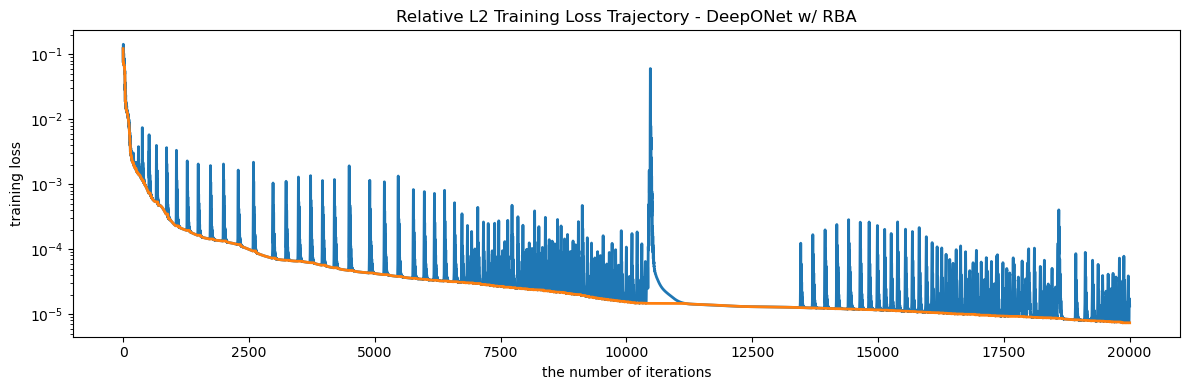

In [12]:
NN_pred_final = vmap(lambda f: vmap(lambda x: model(f,x))(train_xt))(jnp.atleast_1d(train_params))
# vmin, vmax = jnp.min(y_tt), jnp.max(y_tt)
rel_l2_error = jnp.sqrt(jnp.sum((train_u - NN_pred_final)**2,axis=1) / jnp.sum(train_u**2,axis=1))
print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

plt.figure(figsize = (12,4))
plt.semilogy(log_loss, linewidth = 2)
plt.semilogy(log_minloss, linewidth =2)
plt.xlabel('the number of iterations')
plt.ylabel('training loss')
plt.title("Relative L2 Training Loss Trajectory - DeepONet w/ RBA")
plt.tight_layout()
# plt.suptitle(title_str + '\n')
plt.savefig("deeponet_rba_training.png")
plt.show()

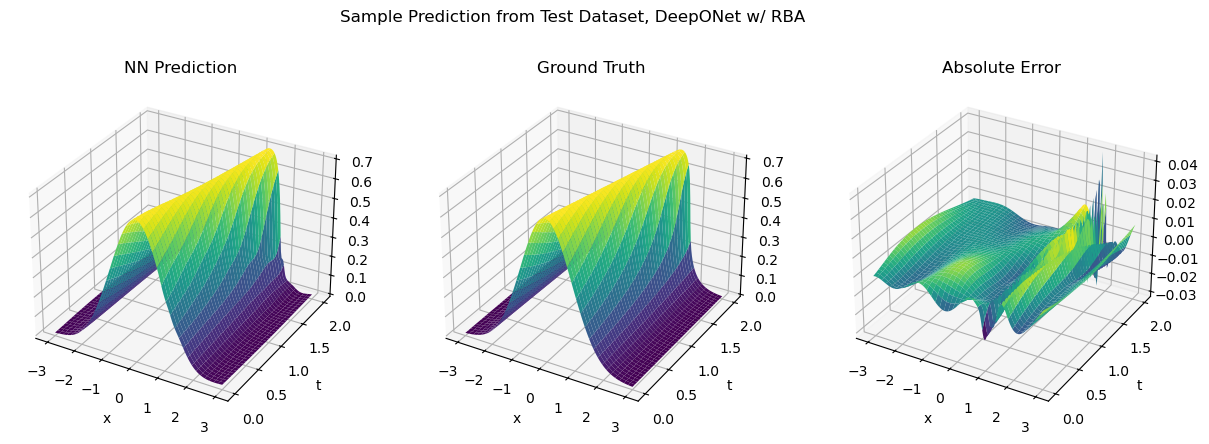

'\nim0 = axes[0].pcolormesh(x, t, pred, cmap="viridis", shading="auto")\naxes[0].set_title("NN Prediction")\naxes[0].set_xlabel("x")\naxes[0].set_ylabel("t")\nfig.colorbar(im0, ax=axes[0], fraction=0.02)\n\nim1 = axes[1].pcolormesh(x, t, truth, cmap="viridis", shading="auto")\naxes[1].set_title("Ground Truth")\naxes[1].set_xlabel("x")\naxes[1].set_ylabel("t")\nfig.colorbar(im1, ax=axes[1], fraction=0.02)\nplt.suptitle("Sample Prediction from Test Dataset, DeepONet Classic")\nplt.savefig("deeponet_classic_prediction.png", dpi=300)\nplt.show()\n'

In [13]:
NN_pred_final = vmap(lambda f: vmap(lambda x: model(f,x))(test_xt))(jnp.atleast_1d(test_params))


x = train_xt[:, 0].reshape(201, 201)
t = train_xt[:, 1].reshape(201, 201)

pred = NN_pred_final[0].reshape(201, 201)
truth = train_u[0].reshape(201, 201)

#fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='3d'))


im0 = axes[0].plot_surface(x, t, pred, cmap="viridis")
axes[0].set_title("NN Prediction")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
#fig.colorbar(im0, ax=axes[0], fraction=0.02)

im1 = axes[1].plot_surface(x, t, truth, cmap="viridis")
axes[1].set_title("Ground Truth")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")

im1 = axes[2].plot_surface(x, t, pred - truth, cmap="viridis")
axes[2].set_title("Absolute Error")
axes[2].set_xlabel("x")
axes[2].set_ylabel("t")
#fig.colorbar(im1, ax=axes[1], fraction=0.02)
plt.suptitle("Sample Prediction from Test Dataset, DeepONet w/ RBA")
plt.savefig("deeponet_rba_prediction.png", dpi=300)
plt.show()


"""
im0 = axes[0].pcolormesh(x, t, pred, cmap="viridis", shading="auto")
axes[0].set_title("NN Prediction")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
fig.colorbar(im0, ax=axes[0], fraction=0.02)

im1 = axes[1].pcolormesh(x, t, truth, cmap="viridis", shading="auto")
axes[1].set_title("Ground Truth")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
fig.colorbar(im1, ax=axes[1], fraction=0.02)
plt.suptitle("Sample Prediction from Test Dataset, DeepONet Classic")
plt.savefig("deeponet_classic_prediction.png", dpi=300)
plt.show()
"""

(40401, 16)


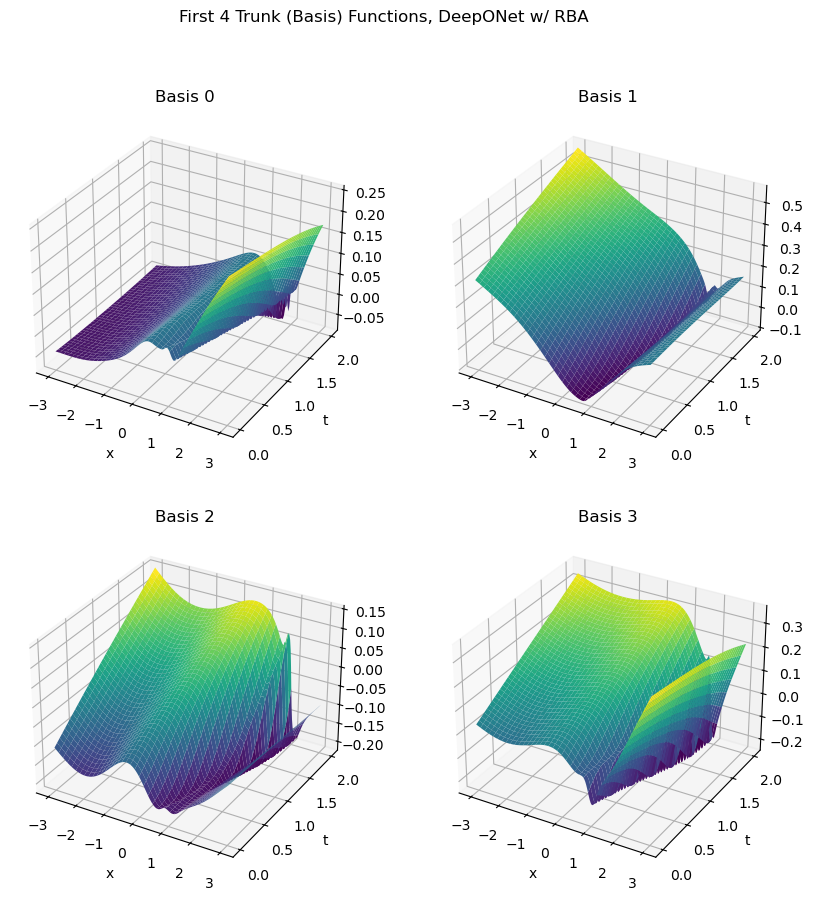

In [14]:
trunk_final = vmap(lambda x: model.trunk(x))(test_xt)
print(trunk_final.shape)
bases = trunk_final[:,:4]

nfuncs = 4
fig, axes = plt.subplots(2, 2, figsize=(10, 10), subplot_kw=dict(projection='3d'))

axes = axes.flatten()

for k,ax in enumerate(axes):
    b = bases[:,k].reshape(201,201)
    im = ax.plot_surface(x,t,b, cmap = 'viridis')
    ax.set_title(f"Basis {k}")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    #fig.colorbar(im, ax = ax, fraction = 0.02)

plt.suptitle("First 4 Trunk (Basis) Functions, DeepONet w/ RBA")
plt.savefig("deeponet_rba_bases.png", dpi = 300)
